<img src="Scoreboard.jpg" width=800 height=1900>

<h1><center> Predicting The Colle Experience Using College Scorecard <center></h1>

<center><b>Zion Joseph, Kelli Webber</b></center>

<h1><center>Introduction</center></h1>
<h3>Right after highschool, students are often faced with the decision of going to college. Most students want to go to school where they feel would be best for them. College is an expensive commitment, and so students may look into a variety of factors. Often this comes down to wether the or not the college feels the most comfortable for students, but it might also be some of the demographics. When applying for schools, students coul look at the schools location, number of undergrads, base truition and demographics of people who already go to the college in order to predict if the school is the right fit.</h3>

<h3>While using data from a college scorecord my group wanted to know if it would be possible to predict what type of school would best fit a certain demographic.The data we are using was last updated on October 30th, 2018.</h3>
<h1><center>Pulling The Data</center></h1>
<h2>Importing libaries</h2>

These are the necessary libaries:
> folium: Visualize location data on a map<br />
pandas: Data management and control<br />
sklear: Linear Regression <br />
numpy: Support functions for data <br />
matplotlib: To plot data points<br />
sklearn: Visualize linear regression models<br />
warining: Control over output warnings

In [110]:
%%capture
!pip install folium
import folium
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

<h2>Pulling The Data from CSV</h2>
<h3>The first step after importing all of the libaries is to go ahead and get the data. This data has been provided by <a href ='https://collegescorecard.ed.gov/data/'>collegescorecard.ed.gov</a>, and is also avaliable on ZionJoseph.github.io. This data has been collected by the government</h3>

In [111]:
#use pandas read_csv to pull the data from the csv file into a variable named odata(original data)
odata = pd.read_csv("Most-Recent-Cohorts-All-Data-Elements.csv")
#display the first coulple of rows inside of the new dataframe
odata.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP6_FTNFT_POOLED_SUPP,OMAWDP8_FTNFT_POOLED_SUPP,OMENRYP8_FTNFT_POOLED_SUPP,OMENRAP8_FTNFT_POOLED_SUPP,OMENRUP8_FTNFT_POOLED_SUPP,OMAWDP6_PTNFT_POOLED_SUPP,OMAWDP8_PTNFT_POOLED_SUPP,OMENRYP8_PTNFT_POOLED_SUPP,OMENRAP8_PTNFT_POOLED_SUPP,OMENRUP8_PTNFT_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www2.aamu.edu/scripts/netpricecalc/npcalc.htm,...,0.4694,0.5136,0.0034,0.1429,0.3401,0.3333,0.3333,0,0,0.6667
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,uab.studentaidcalculator.com/survey.aspx,...,0.6117,0.624,0.0075,0.2166,0.1519,0.3642,0.4,0.0434,0.2755,0.2811
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,...,0.5503,0.5562,0.0059,0.4379,0,0.4429,0.4714,0.0429,0.4857,0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.5456,0.5651,0.0123,0.2841,0.1385,0.3378,0.3547,0.0236,0.4257,0.1959
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.4105,0.429,0.0062,0.216,0.3488,0.2931,0.3103,0.0345,0.3966,0.2586


<h3>Now there is a slight problem with our current dataset; it has too much columns!. Many of these colums are for data that won't be necessary. so we will get rid of the columns for these ones. </h3>

<h2>Tidying of Columns</h2>
<h3>To make our dataframe more easier to use,  make a new variable named data to hold the dataframe with our specified columns</h3>


The column names are as follows:
> INSTNM: For the name of the institution<br />
CITY: Name of th city the college is in<br />
STABBR: State abbreviation<br />
LONGITUDE: Longitude for school location<br />
LATITUDE: Latitude for school location <br />
MENONLY: Wether school is only for men<br />
WOMENONLY: Wether school is only for women<br />
ADM_RATE: The decimal rate of acceptance <br />
TUITIONFEE_IN: The in state tuition for the college<br />
TUITIONFEE_OUT: The out of state tution for the college<br />
UGDS: Number of undergraduates<br />
AGE_ENTRY: Average age of students entering that university<br />

In [112]:
# Choose specific columns to have in new dataframe
data = odata[['INSTNM', 'CITY', 'STABBR', 'LONGITUDE', 'LATITUDE', 'MENONLY', 'WOMENONLY','UGDS_WHITE', 'UGDS_BLACK', 'UGDS_ASIAN', 'UGDS_HISP','UGDS_NHPI','UGDS_AIAN', 'ADM_RATE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'UGDS', 'AGE_ENTRY']]
# display the first couple of values of the new dataframe
data.head()

,INSTNM,CITY,STABBR,LONGITUDE,LATITUDE,MENONLY,WOMENONLY,UGDS_WHITE,UGDS_BLACK,UGDS_ASIAN,UGDS_HISP,UGDS_NHPI,UGDS_AIAN,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,UGDS,AGE_ENTRY
0,Alabama A & M University,Normal,AL,-86.568502,34.783368,0.0,0.0,0.0256,0.9129,0.0019,0.0076,0.0017,0.0024,0.8738,9366.0,17496.0,4616.0,20.283741368
1,University of Alabama at Birmingham,Birmingham,AL,-86.799345,33.505697,0.0,0.0,0.5786,0.2626,0.0598,0.0309,0.0004,0.0028,0.5814,8040.0,18368.0,12047.0,23.60797466
2,Amridge University,Montgomery,AL,-86.174010,32.362609,0.0,0.0,0.1570,0.2355,0.0000,0.0068,0.0034,0.0000,NaN,7180.0,7180.0,293.0,33.672297297
3,University of Alabama in Huntsville,Huntsville,AL,-86.640449,34.724557,0.0,0.0,0.7148,0.1131,0.0414,0.0411,0.0000,0.0120,0.7628,9842.0,20612.0,6346.0,22.727919632
4,Alabama State University,Montgomery,AL,-86.295677,32.364317,0.0,0.0,0.0138,0.9337,0.0028,0.0111,0.0004,0.0013,0.4590,9220.0,16156.0,4704.0,20.130990415


In order to make the data more readable, some data that can be represented in one column should be put together. Looking at our data, the columns MENONLY and WOMENONLY are both essentially the same, and so we can reduce these columns into one. 

In [113]:
#Tidying the MENONLY and WOMENONLY column
#New variable to hold combined series
gender = []
#Iterate through each row of the dataset
for index, row in data.iterrows():
    # checks to see if menonly, womenonly, nan, or CO-ED
    if np.isnan(row ['WOMENONLY']) | np.isnan(row ['MENONLY']):
        gender.append(float('nan'))
    elif (row ['WOMENONLY'] == 1.) & (row ['MENONLY'] == 0.):
        gender.append('WOMENONLY')
    elif (row ['MENONLY'] == 1.) & (row ['WOMENONLY'] == 0.):
        gender.append('MENONLY')
    else:# (row ['WOMENONLY']) == 0. & (row ['MENONLY']) == 0.:
        gender.append('CO-ED')
# drop redundant columns       
data = data.drop(columns=['WOMENONLY', 'MENONLY'])
# add new column gender
data['GENDER']= gender

# Reorganize the columns to reflect gender to where menonly and womenonly used to be
data = data[['INSTNM', 'CITY', 'STABBR', 'LONGITUDE', 'LATITUDE', 'GENDER', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_ASIAN', 'UGDS_HISP','UGDS_NHPI','UGDS_AIAN','ADM_RATE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'UGDS', 'AGE_ENTRY']]
# display the first couple of values of the new dataframe
data.head()

,INSTNM,CITY,STABBR,LONGITUDE,LATITUDE,GENDER,UGDS_WHITE,UGDS_BLACK,UGDS_ASIAN,UGDS_HISP,UGDS_NHPI,UGDS_AIAN,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,UGDS,AGE_ENTRY
0,Alabama A & M University,Normal,AL,-86.568502,34.783368,CO-ED,0.0256,0.9129,0.0019,0.0076,0.0017,0.0024,0.8738,9366.0,17496.0,4616.0,20.283741368
1,University of Alabama at Birmingham,Birmingham,AL,-86.799345,33.505697,CO-ED,0.5786,0.2626,0.0598,0.0309,0.0004,0.0028,0.5814,8040.0,18368.0,12047.0,23.60797466
2,Amridge University,Montgomery,AL,-86.174010,32.362609,CO-ED,0.1570,0.2355,0.0000,0.0068,0.0034,0.0000,NaN,7180.0,7180.0,293.0,33.672297297
3,University of Alabama in Huntsville,Huntsville,AL,-86.640449,34.724557,CO-ED,0.7148,0.1131,0.0414,0.0411,0.0000,0.0120,0.7628,9842.0,20612.0,6346.0,22.727919632
4,Alabama State University,Montgomery,AL,-86.295677,32.364317,CO-ED,0.0138,0.9337,0.0028,0.0111,0.0004,0.0013,0.4590,9220.0,16156.0,4704.0,20.130990415


<h1><center>Visualization and Anaylsis</center><h1>
<h2>Visualization of college locations</h2>

In [114]:
map_osm = folium.Map(location=[39.29, -100.61], zoom_start=4)
sampdata = data.sample(n = 1000)
noNaN = sampdata.dropna(subset = ['LATITUDE', 'LONGITUDE'])

for index, row in noNaN.iterrows():   
    color= 'black'
    folium.Circle(
    tooltip=row['INSTNM'],
    radius=40000,
    location=[row['LATITUDE'], row['LONGITUDE']],
    color=color,
    fill=True,
).add_to(map_osm)
    
map_osm

<h3>This map shows that the data primarly focuses on the eastern side of the United States. The map also has some sparse data from the US territories as well as the western side of the United States</h3>
<img src="US-Universities.png" width=800 height=1900>
<h2><center>Exploratory Data analysis</center></h2>

In [115]:
admissions = data.dropna(subset = ['INSTNM', 'ADM_RATE'])
admissions= admissions.groupby(['STABBR'], as_index=False)['ADM_RATE', 'UGDS'].mean()
admissions.head()

,STABBR,ADM_RATE,UGDS
0,AK,0.650850,4641.000000
1,AL,0.638853,4839.566667
2,AR,0.697232,4154.105263
3,AZ,0.676111,10085.736842
4,CA,0.612773,5656.950704


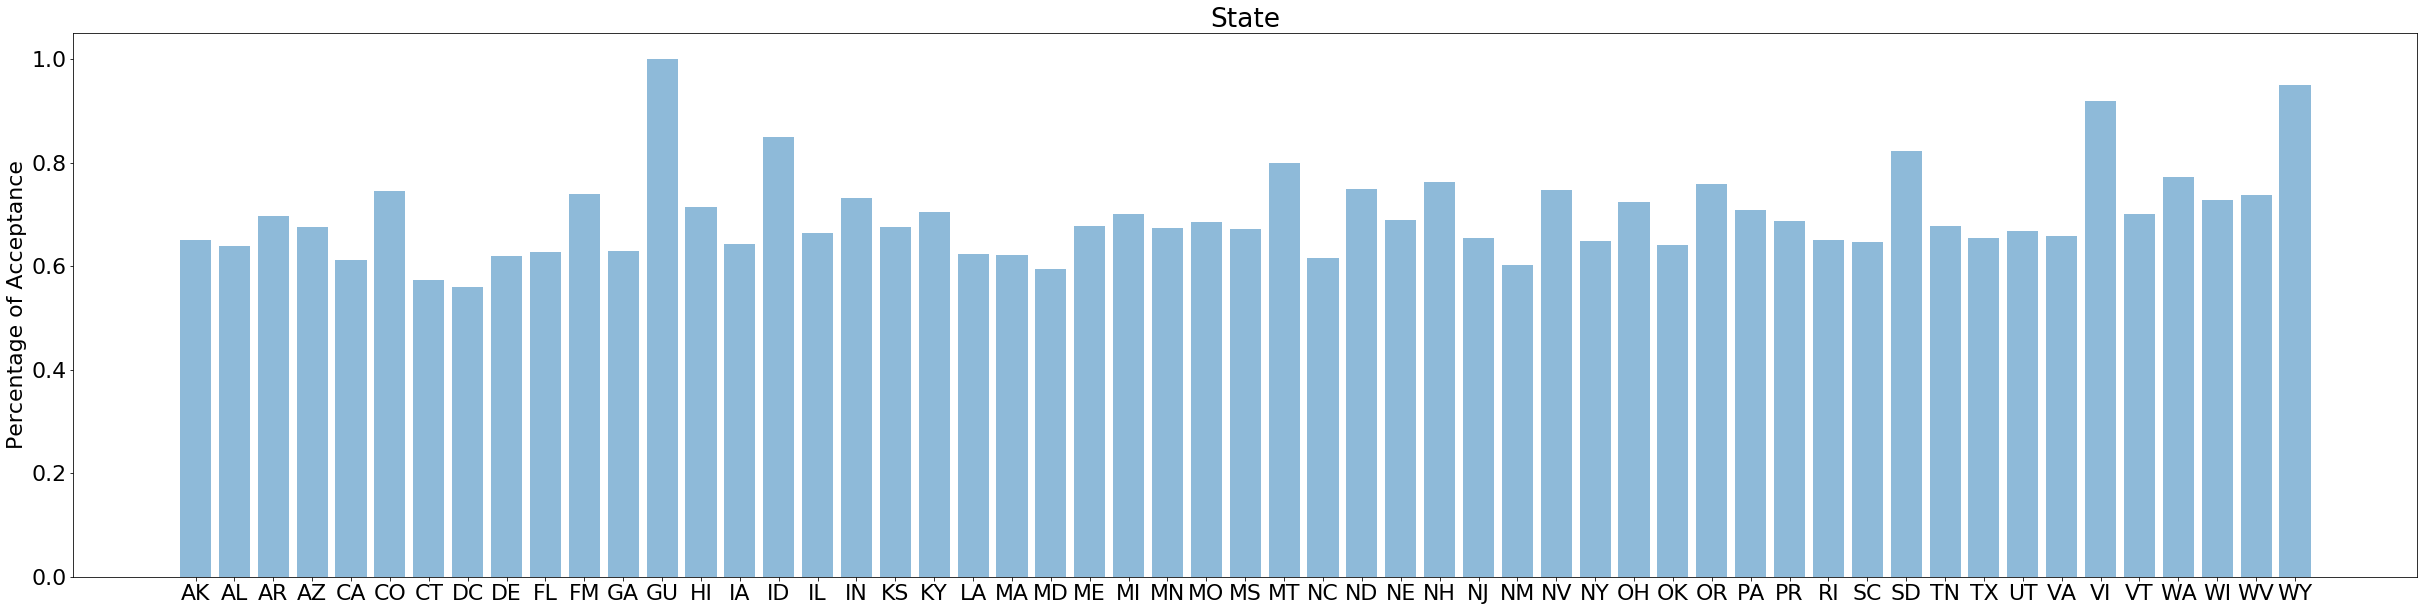

In [116]:
plt.figure(num=None, figsize=(42, 10))
x = admissions['STABBR']
y = admissions['ADM_RATE']
plt.rcParams.update({'font.size': 22})
plt.bar(x, y, align='center', alpha=0.5)
plt.ylabel('Percentage of Acceptance')
plt.title('State')
 
plt.show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

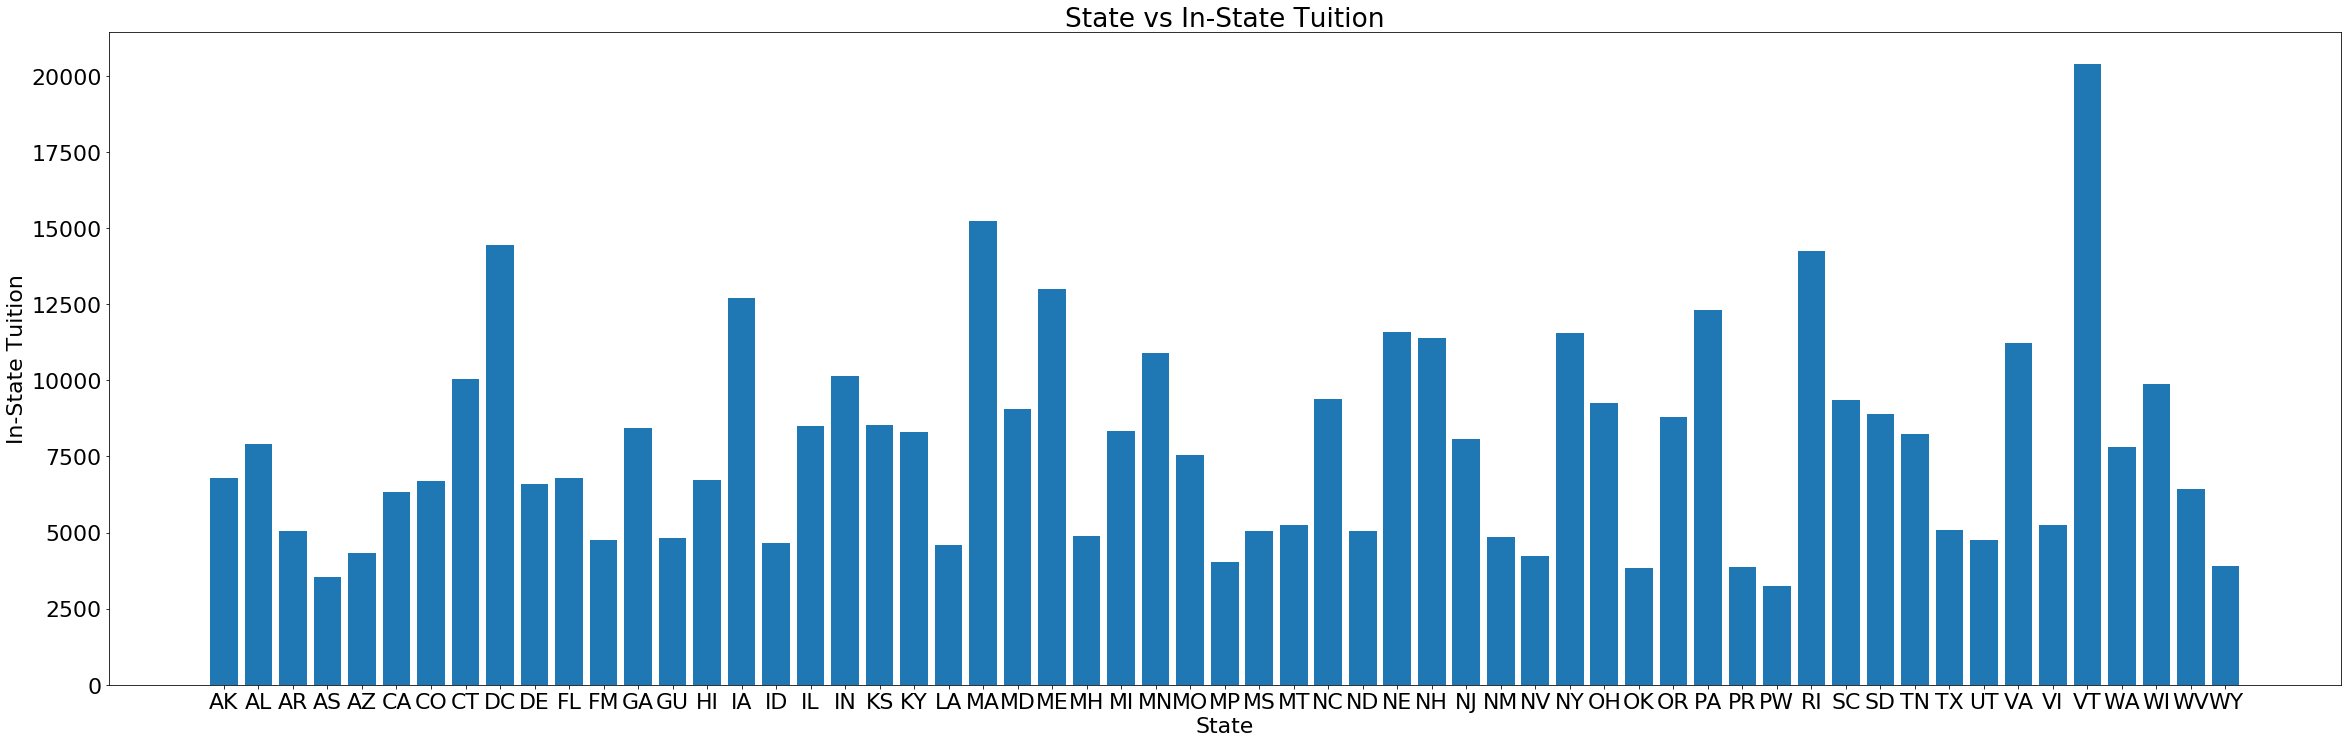

In [127]:
fig = plt.figure(figsize=(40,12))
plot = fig.add_subplot(1,1,1)

State_Abbr = []
for ele, df in data.groupby('STABBR'):   
    State_Abbr.append(str(ele))

tuition_averages = []
for b, df in data.groupby('STABBR'):   
    t = df['TUITIONFEE_IN'].sum()
    c = len(df['TUITIONFEE_IN'])
    tuition_averages.append(t/c)

x_pos = [i for i, _ in enumerate(State_Abbr)]
plt.bar(State_Abbr, tuition_averages)
plot.set_title('State vs In-State Tuition')
plot.set_xlabel('State')
plot.set_ylabel('In-State Tuition')
plt

<h1><center>Predicting Tutition based on Demographics</center><h1>
<h3>In order to properly pake a prediction of what college may be best suited for a certain demographic, A person has to look at diffrent variables. To do this, you can make an interaction term between two variables and use that interaction to predict another variable outcome. <h3>
<h2>Creating the Interaction Term<h2>
<h3>TWe will be creating an interaction term between the variables of Racial Percentages and STABBR to predict a college's In-State Tuition. This interaction term will be able to predict what a College's In-State tuition would be like depending on their racial demographic.

In [119]:
# Hashmap for each State and territory
States = {"AL":1,"AK":2,"AZ":3,"AR":4,"CA":5,"CO":6,"CT":7,"DE":8,"FL":9,  \
          "GA":10,"HI":11,"ID":12,"IL":13,"IN":14,"IA":15,"KS":16,"KY":17, \
          "LA":18,"ME":19,"MD":20,"MA":21,"MI":22,"MN":23,"MS":24,"MO":25, \
          "MT":26,"NE":27,"NV":28,"NH":29,"NJ":30,"NM":31,"NY":32,"NC":33, \
          "ND":34,"OH":35,"OK":36,"OR":37,"PA":38,"RI":39,"SC":40,"SD":41, \
          "TN":42,"TX":43,"UT":44,"VT":45,"VA":46,"WA":47,"WV":48,"WI":49, \
          "WY":50, "DC":20, "AS" : 51, "GU" : 52, "MP" :53, "PR":54, "FM":55, "PW":56, "VI":57, "MH":58}
# list of Column headers identifying races 
races = ['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_ASIAN', 'UGDS_HISP','UGDS_NHPI','UGDS_AIAN']
# HashMap for more human readable ids
race = {'UGDS_WHITE':'WHITE', 'UGDS_BLACK':'BLACK', 'UGDS_ASIAN':'ASIAN', 'UGDS_HISP':'HISPANIC','UGDS_NHPI':'NHPI', \
        'UGDS_AIAN':'AIAN'}
inter ={}
# Create a new datafram that is not missing any of the values

#fit and store a regression for each interaction between race
for ele in races:
    poly = PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)
    x = []
    # Create a new datafram that is not missing any of the racial, 
    noNaN = data.dropna(subset = ['STABBR', ele ,'TUITIONFEE_IN'])
    #iterate through datafram and add a pair (Racial Precent and State Hashed NUmber)
    for index,row in noNaN.iterrows():
        x.append([row[ele],States[row['STABBR']]])
    #Create regression 
    poly.fit_transform(x)
    reg = LinearRegression().fit(x,noNaN['TUITIONFEE_IN'])
    #Store regression in specific racial hash
    inter[ele] = reg
    print("intercept for Race:" + race[ele]+ "\'s Demographic %f:" % reg.intercept_)
    print("coefficients for Race:" + race[ele] + "\'s Demographic %f, %f:" % (reg.coef_[0],reg.coef_[1]))

intercept for Race:WHITE's Demographic 12197.193466:
coefficients for Race:WHITE's Demographic 5493.388337, -5.337322:
intercept for Race:BLACK's Demographic 16108.591560:
coefficients for Race:BLACK's Demographic -6311.780052, -4.218603:
intercept for Race:ASIAN's Demographic 13247.135139:
coefficients for Race:ASIAN's Demographic 30249.762112, 23.063289:
intercept for Race:HISPANIC's Demographic 16236.359583:
coefficients for Race:HISPANIC's Demographic -10730.813535, 11.638435:
intercept for Race:NHPI's Demographic 14941.486629:
coefficients for Race:NHPI's Demographic -12065.450924, 2.769065:
intercept for Race:AIAN's Demographic 15158.174795:
coefficients for Race:AIAN's Demographic -16247.819805, 2.361075:


<h2>Using the Interaction Term</h2>
<h3>Now that we have the interaction term, we should use it. Using a specific race, demographic percetage, and State we can predict how high the instate tuition for a college will be. Lets try to predict the instate tuition of a college in Maryland that has a 40% polulation of asians</h3>

In [120]:
inter["UGDS_ASIAN"].predict([[.4, States["MD"]]])[0]

25808.305758805633

<h3>As we can see, the in-state tuition for a college in maryland that has a demographic of 40% Asian will have a tuition of $25,808.30</h3>
<h2>Visualizing the prediction</h2>
<h3>In order to now visualize the prediction better, we can plot several predictions for each race. For example, using Maryland we can loop through percetages and plot the prediction at each point. </h3>

Text(0,0.5,'In State Tuition')

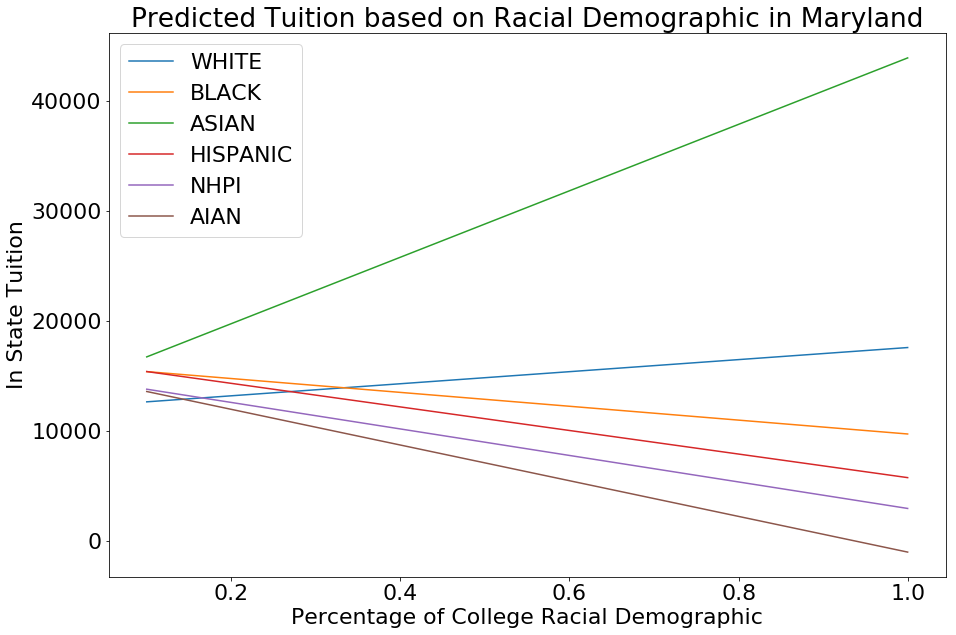

In [121]:
# Create a new figure to hold the plot
fig = plt.figure(figsize=(15,10))  
# Add the subplot
plot = fig.add_subplot(1,1,1)

# for each race, predict 10  percetage values for tuition
for ele in races:
    i = .1
    x = []
    while i < 1:   
        # Add the prediction to the end of x
        x.extend([inter[ele].predict([[i,States["MD"]]])])
        i = i + .1
    plt.plot([.1,.2,.3,.4,.5,.6,.7,.8,.9,1],x)
#legend
plot.legend(['WHITE', 'BLACK', 'ASIAN', 'HISPANIC','NHPI','AIAN'])
plot.set_title("Predicted Tuition based on Racial Demographic in Maryland")
plot.set_xlabel("Percentage of College Racial Demographic")
plot.set_ylabel("In State Tuition")

<h3>What we can see from this graph is that as the precentage of certain races increase in Maryland schools, there predicted instate tuition prices change. This is quite important, because racial demographics are a important part of the college decision making process. In This example we see that Asian's specifically have a very large increase in tuition prices as their demographic precetage increases.</h3>
<h1><center>Conclusion</center></h1>
<h2>Through the anaylsis of the data on this college score card we have been able to see several trends for many diffrent demographics in college. When looking for a college, often people will look for specific flags that they like, but it isn't easy to find this sort of data from a college website. Through the steps of the data science cylce, we have been able to learn alot about how to best make use of data. We have learned that the processing of the right dataset is very important as it decides what you can or cannot do with your data, and also the various ways of analysis and visualization that can go into interpreting data. </h2>